In [8]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [9]:
# old way (n2v on "Single")
data_path = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_OnInpSnr2_mse"
files = os.listdir(data_path)

signal = []
observation =[]
for file in files:
    im = imread(os.path.join(data_path,file))
    observation.append(im[0])
    signal.append(im[1])

# Stack to numpy array
signal = np.stack(signal)
observation = np.stack(observation)

print(signal.shape,observation.shape)
print("Signal:", np.mean(signal),np.std(signal),np.min(signal),np.max(signal))
print("Observation:", np.mean(observation),np.std(observation),np.min(observation),np.max(observation))


signal_norm = (signal - np.mean(signal)) / np.std(signal)
observation_norm = (observation - np.mean(observation)) / np.std(observation)
print("After normalization:")
print("Signal:", np.mean(signal_norm),np.std(signal_norm),np.min(signal_norm),np.max(signal_norm))
print("Observation:", np.mean(observation_norm),np.std(observation_norm),np.min(observation_norm),np.max(observation_norm))


(21, 1200, 1200) (21, 1200, 1200)
Signal: 26.333721 39.79483 -6.286812 1385.8855
Observation: 26.506794 51.458996 0.0 1870.694
After normalization:
Signal: 2.4422135e-07 1.0000006 -0.8197179 34.16403
Observation: -2.768784e-07 0.9999996 -0.5151051 35.837994


In [10]:
histogram_old = histNoiseModel.createHistogram(512, 0, 1420, observation,signal)
histogram_old_norm = histNoiseModel.createHistogram(512, -0.5, 44, observation_norm,signal_norm)

Text(0.5, 1.0, 'Old - with norm')

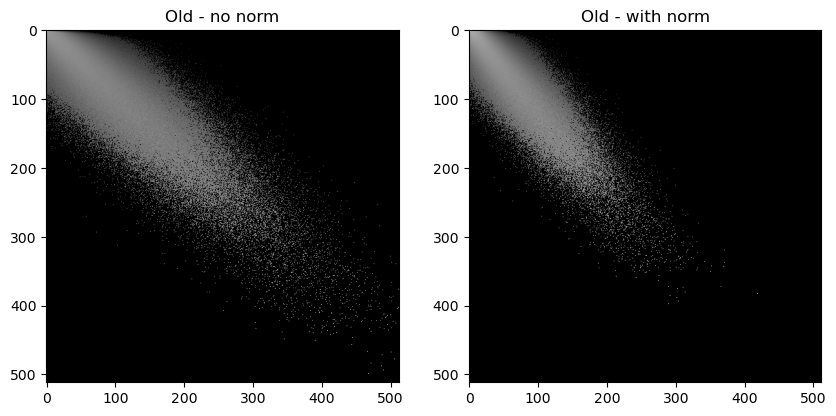

In [11]:
pwr = 0.15
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(histogram_old[0]**pwr,cmap='gray')
plt.title("Old - no norm")
plt.subplot(1,2,2)
plt.imshow(histogram_old_norm[0]**pwr,cmap='gray')
plt.title("Old - with norm")

In [12]:
# New way (clean = avg or n2v(avg))

# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Center crop 1200 (=same as data "old way")
crop_size = 1200
hx=1392
hy=1416
x1 = hx//2-crop_size//2
x2 = hx//2+crop_size//2
y1 = hy//2-crop_size//2
y2 = hy//2+crop_size//2


# Choose parameters
noise_level = 3 # 
clip = -3 # False or clip value
registration = True

signal_avg = []
signal_n2v = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    im_signal_avg = imread(data_path_signal / file_signal)[0,y1:y2,x1:x2]
    im_signal_n2v = imread(data_path_signal / file_signal)[1,y1:y2,x1:x2]
    im_obs = imread(data_path_obs / file_obs)[noise_level,y1:y2,x1:x2]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal_avg[im_signal_avg<clip] = 0
        im_signal_n2v[im_signal_n2v<clip] = 0

    if registration:
        tf = StackReg.TRANSLATION
        sr = StackReg(tf)
        tmat = sr.register(ref=im_signal_avg,mov=im_obs)
        tform = AffineTransform(matrix=tmat)
        im_obs = warp(im_obs, tform,order=0)

    observation.append(im_obs)
    signal_avg.append(im_signal_avg)
    signal_n2v.append(im_signal_n2v)


# Stack to numpy array
signal_avg = np.stack(signal_avg)
signal_n2v = np.stack(signal_n2v)
observation = np.stack(observation)

print(signal.shape,observation.shape)
print("Signal average:", np.mean(signal_avg),np.std(signal_avg),np.min(signal_avg),np.max(signal_avg))
print("Signal n2v(average):", np.mean(signal_n2v),np.std(signal_n2v),np.min(signal_n2v),np.max(signal_n2v))
print("Observation:", np.mean(observation),np.std(observation),np.min(observation),np.max(observation))


signal_avg_norm = (signal_avg - np.mean(signal_avg)) / np.std(signal_avg)
signal_n2v_norm = (signal_n2v - np.mean(signal_n2v)) / np.std(signal_n2v)
observation_norm = (observation - np.mean(observation)) / np.std(observation)
print("After normalization:")
print("Signal average:", np.mean(signal_avg_norm),np.std(signal_avg_norm),np.min(signal_avg_norm),np.max(signal_avg_norm))
print("Signal n2v(average):", np.mean(signal_n2v_norm),np.std(signal_n2v_norm),np.min(signal_n2v_norm),np.max(signal_n2v_norm))
print("Observation:", np.mean(observation_norm),np.std(observation_norm),np.min(observation_norm),np.max(observation_norm))



Found 25 files.

(21, 1200, 1200) (25, 1200, 1200)
Signal average: 25.157568 56.258373 -2.9999988 1975.89
Signal n2v(average): 19.155342 51.820892 -3.0 1724.8889
Observation: 26.194466 50.22509 -2.9999962 1870.694
After normalization:
Signal average: 2.0735e-08 1.0000005 -0.50050443 34.674526
Signal n2v(average): 1.8153212e-07 1.0000012 -0.42753688 32.915943
Observation: -3.2941014e-07 0.9999996 -0.5812725 36.724663


In [13]:
histogram_new_avg = histNoiseModel.createHistogram(512, -3, 2000, observation,signal_avg)
histogram_new_n2v = histNoiseModel.createHistogram(512, -3, 1700, observation,signal_n2v)
histogram_new_avg_norm = histNoiseModel.createHistogram(512, -0.5, 35, observation_norm,signal_avg_norm)
histogram_new_n2v_norm  = histNoiseModel.createHistogram(512, -0.5, 32, observation_norm,signal_n2v_norm)

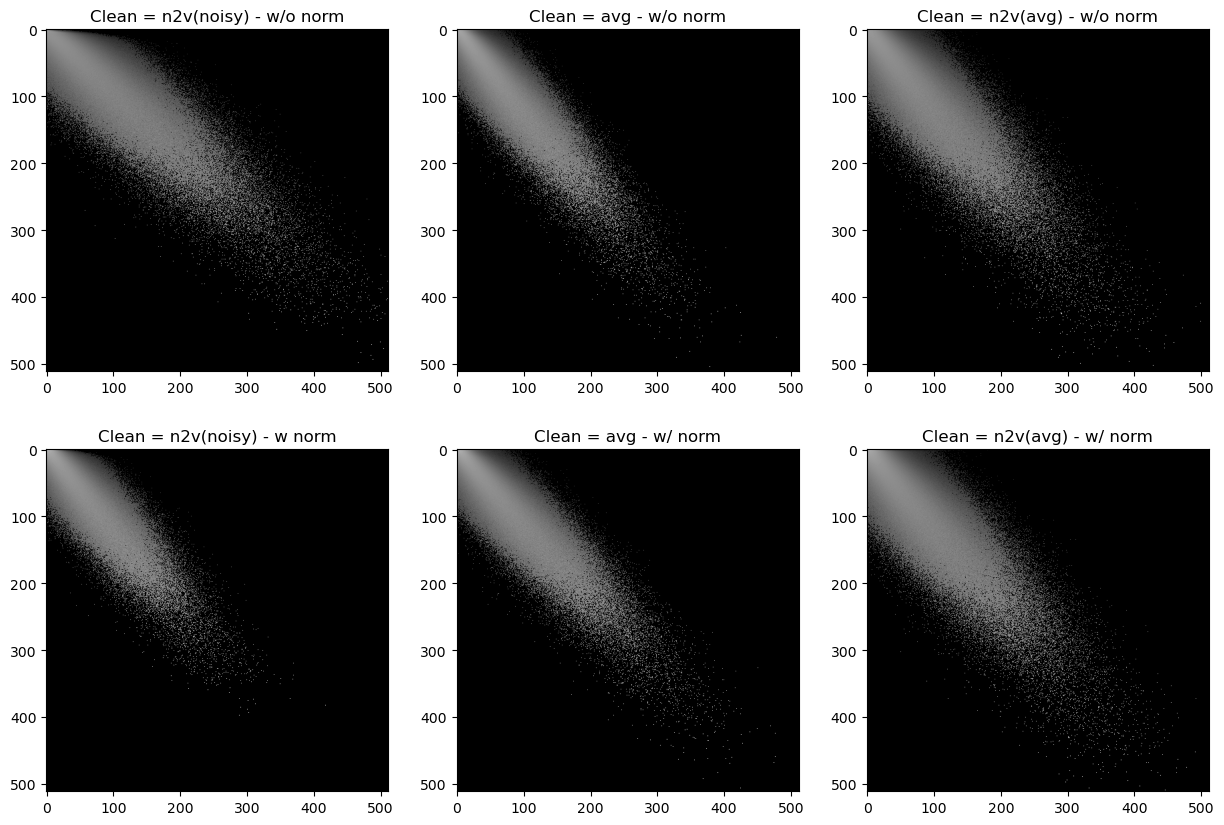

In [14]:
# Display all
plt.figure(figsize=(15,10))
pwr = 0.15

plt.subplot(2,3,1)
plt.imshow(histogram_old[0]**pwr,cmap='gray')
plt.title("Clean = n2v(noisy) - w/o norm")
plt.subplot(2,3,4)
plt.imshow(histogram_old_norm[0]**pwr,cmap='gray')
plt.title("Clean = n2v(noisy) - w norm")
plt.subplot(2,3,2)
plt.imshow(histogram_new_avg[0]**pwr,cmap='gray')
plt.title("Clean = avg - w/o norm")
plt.subplot(2,3,5)
plt.imshow(histogram_new_avg_norm[0]**pwr,cmap='gray')
plt.title("Clean = avg - w/ norm")
plt.subplot(2,3,3)
plt.imshow(histogram_new_n2v[0]**pwr,cmap='gray')
plt.title("Clean = n2v(avg) - w/o norm")
plt.subplot(2,3,6)
plt.imshow(histogram_new_n2v_norm[0]**pwr,cmap='gray')
plt.title("Clean = n2v(avg) - w/ norm")
plt.show()